In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader

## Load Data

In [3]:
def read_bci_data():
    S4b_train = np.load('S4b_train.npz')
    X11b_train = np.load('X11b_train.npz')
    S4b_test = np.load('S4b_test.npz')
    X11b_test = np.load('X11b_test.npz')

    train_data = np.concatenate((S4b_train['signal'], X11b_train['signal']), axis=0)
    train_label = np.concatenate((S4b_train['label'], X11b_train['label']), axis=0)
    test_data = np.concatenate((S4b_test['signal'], X11b_test['signal']), axis=0)
    test_label = np.concatenate((S4b_test['label'], X11b_test['label']), axis=0)

    train_label = train_label - 1
    test_label = test_label -1
    train_data = np.transpose(np.expand_dims(train_data, axis=1), (0, 1, 3, 2))
    test_data = np.transpose(np.expand_dims(test_data, axis=1), (0, 1, 3, 2))

    mask = np.where(np.isnan(train_data))
    train_data[mask] = np.nanmean(train_data)

    mask = np.where(np.isnan(test_data))
    test_data[mask] = np.nanmean(test_data)

    print(train_data.shape, train_label.shape, test_data.shape, test_label.shape)

    return train_data, train_label, test_data, test_label

## Build Models

In [4]:
class EEGNet(nn.Module):

    def __init__(self, activation='ELU'):
        super(EEGNet, self).__init__()

        if activation == 'ELU':
            self.activation = nn.ELU(alpha=1.0)
        elif activation == 'ReLU':
            self.activation = nn.ReLU()
        elif activation == 'LeakyReLU':
            self.activation = nn.LeakyReLU(negative_slope=0.01)

        self.FirstConv2D = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=(1, 51), stride=(1, 1), padding=(0, 25), bias=False),
            nn.BatchNorm2d(16, eps=1e-5, momentum=0.1, affine=True, track_running_stats=True)
        )

        self.DepthwiseConv2D = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=(2, 1), stride=(1, 1), groups=16, bias=False),
            nn.BatchNorm2d(32, eps=1e-5, momentum=0.1, affine=True, track_running_stats=True),
            self.activation,
            nn.AvgPool2d(kernel_size=(1, 4), stride=(1, 4), padding=0),
            nn.Dropout(p=0.25)
        )

        self.SeparableConv2D = nn.Sequential(
            nn.Conv2d(32, 32, kernel_size=(1, 15), stride=(1, 1), padding=(0, 7), bias=False),
            nn.BatchNorm2d(32, eps=1e-5, momentum=0.1, affine=True, track_running_stats=True),
            self.activation,
            nn.AvgPool2d(kernel_size=(1, 8), stride=(1, 8), padding=0),
            nn.Dropout(p=0.25),
            nn.Flatten()
        )

        self.Classification = nn.Sequential(
            nn.Linear(in_features=736, out_features=2, bias=True)
        )

    def forward(self, x):
        x = self.FirstConv2D(x)
        x = self.DepthwiseConv2D(x)
        x = self.SeparableConv2D(x)
        x = self.Classification(x)

        return x

In [5]:
class DeepConvNet(nn.Module):

    def __init__(self, activation='ELU'):

        super(DeepConvNet, self).__init__()

        if activation == 'ELU':
            self.activation = nn.ELU(alpha=1.0)
        elif activation == 'ReLU':
            self.activation = nn.ReLU()
        elif activation == 'LeakyReLU':
            self.activation = nn.LeakyReLU(negative_slope=0.01)

        self.conv1 = nn.Sequential(
            nn.Conv2d(1, 25, kernel_size=(1, 5), stride=(1, 1)),
            nn.Conv2d(25, 25, kernel_size=(2, 1), stride=(1, 1)),
            nn.BatchNorm2d(25, eps=1e-5, momentum=0.1, affine=True, track_running_stats=True),
            self.activation,
            nn.MaxPool2d((1, 2), stride=(1, 2)),
            nn.Dropout(p=0.5)
        )

        self.conv2 = nn.Sequential(
            nn.Conv2d(25, 50, kernel_size=(1, 5), stride=(1, 1)),
            nn.BatchNorm2d(50, eps=1e-5, momentum=0.1, affine=True, track_running_stats=True),
            self.activation,
            nn.MaxPool2d((1, 2), stride=(1, 2)),
            nn.Dropout(p=0.5)
        )

        self.conv3 = nn.Sequential(
            nn.Conv2d(50, 100, kernel_size=(1, 5), stride=(1, 1)),
            nn.BatchNorm2d(100, eps=1e-5, momentum=0.1, affine=True, track_running_stats=True),
            self.activation,
            nn.MaxPool2d((1, 2), stride=(1, 2)),
            nn.Dropout(p=0.5)
        )
        
        self.conv4 = nn.Sequential(
            nn.Conv2d(100, 200, kernel_size=(1, 5), stride=(1, 1)),
            nn.BatchNorm2d(200, eps=1e-5, momentum=0.1, affine=True, track_running_stats=True),
            self.activation,
            nn.MaxPool2d((1, 2), stride=(1, 2)),
            nn.Dropout(p=0.5),
            nn.Flatten()
        )

        self.Classification = nn.Sequential(
            nn.Linear(in_features=8600, out_features=2, bias=True),
            nn.Softmax()
        )

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.Classification(x)

        return x

In [6]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [7]:
x_train, y_train, x_test, y_test = read_bci_data()

(1080, 1, 2, 750) (1080,) (1080, 1, 2, 750) (1080,)


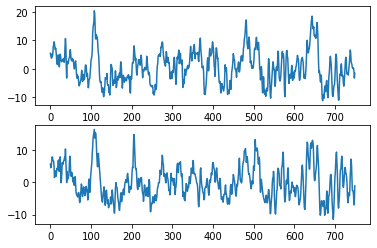

In [8]:
plt.subplot(2, 1, 1)
plt.plot(x_train[0, 0, 0, :])

plt.subplot(2, 1, 2)
plt.plot(x_train[0, 0, 1, :])

plt.show()

In [9]:
x_train = torch.Tensor(x_train).to(device)
y_train = torch.Tensor(y_train).to(device)
x_test = torch.Tensor(x_test).to(device)
y_test = torch.Tensor(y_test).to(device)

In [10]:
trainset = TensorDataset(x_train, y_train)
dataloader = DataLoader(trainset, batch_size=64, shuffle=True)

## Train EEGNet

In [11]:
eeg = EEGNet(activation='ELU')
eeg.cuda()
print(eeg)

EEGNet(
  (activation): ELU(alpha=1.0)
  (FirstConv2D): Sequential(
    (0): Conv2d(1, 16, kernel_size=(1, 51), stride=(1, 1), padding=(0, 25), bias=False)
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (DepthwiseConv2D): Sequential(
    (0): Conv2d(16, 32, kernel_size=(2, 1), stride=(1, 1), groups=16, bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ELU(alpha=1.0)
    (3): AvgPool2d(kernel_size=(1, 4), stride=(1, 4), padding=0)
    (4): Dropout(p=0.25, inplace=False)
  )
  (SeparableConv2D): Sequential(
    (0): Conv2d(32, 32, kernel_size=(1, 15), stride=(1, 1), padding=(0, 7), bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ELU(alpha=1.0)
    (3): AvgPool2d(kernel_size=(1, 8), stride=(1, 8), padding=0)
    (4): Dropout(p=0.25, inplace=False)
    (5): Flatten(start_dim=1, end_dim=-1)
  )
  (Classification): Sequentia

In [12]:
epochs = 2000
optimizer = torch.optim.Adam(eeg.parameters(), lr=1e-3)
crossentropy = nn.CrossEntropyLoss().to(device)

In [13]:
elu_train = []
elu_test = []

for epoch in range(epochs):
    eeg.train()
    for x, label in dataloader:
        x = x.to(device)
        label = label.to(device, dtype=torch.long)
        output = eeg(x)
        loss = crossentropy(output, label)

        # backward propagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # check accurancy of each epoch
    eeg.eval()
    with torch.no_grad():
        output = eeg(x_train)
        pred = np.argmax(output.cpu().detach().numpy(), axis=1)
        elu_train.append(1 - np.average(np.abs(pred - y_train.cpu().detach().numpy())))
        output = eeg(x_test)
        pred = np.argmax(output.cpu().detach().numpy(), axis=1)
        elu_test.append(1 - np.average(np.abs(pred - y_test.cpu().detach().numpy())))

        if epoch % 10 == 0:
            print("epoch %d, training accuracy: %0.6f, testing accuracy: %0.6f"
                  % (epoch, elu_train[-1], elu_test[-1]))

epoch 0, training accuracy: 0.738889, testing accuracy: 0.704630
epoch 10, training accuracy: 0.811111, testing accuracy: 0.732407
epoch 20, training accuracy: 0.857407, testing accuracy: 0.738889
epoch 30, training accuracy: 0.912963, testing accuracy: 0.765741
epoch 40, training accuracy: 0.935185, testing accuracy: 0.777778
epoch 50, training accuracy: 0.951852, testing accuracy: 0.796296
epoch 60, training accuracy: 0.973148, testing accuracy: 0.802778
epoch 70, training accuracy: 0.977778, testing accuracy: 0.802778
epoch 80, training accuracy: 0.986111, testing accuracy: 0.796296
epoch 90, training accuracy: 0.985185, testing accuracy: 0.804630
epoch 100, training accuracy: 0.993519, testing accuracy: 0.808333
epoch 110, training accuracy: 0.988889, testing accuracy: 0.820370
epoch 120, training accuracy: 0.998148, testing accuracy: 0.810185
epoch 130, training accuracy: 0.999074, testing accuracy: 0.809259
epoch 140, training accuracy: 0.998148, testing accuracy: 0.813889
epoch 

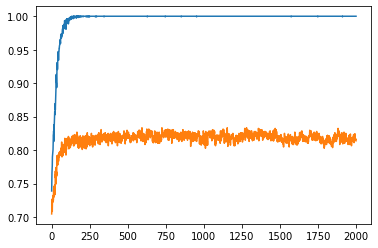

In [14]:
plt.plot(elu_train)
plt.plot(elu_test)

In [15]:
max(elu_test)

0.8333333333333334

In [16]:
eeg = EEGNet(activation='ReLU')
eeg.cuda()
print(eeg)

EEGNet(
  (activation): ReLU()
  (FirstConv2D): Sequential(
    (0): Conv2d(1, 16, kernel_size=(1, 51), stride=(1, 1), padding=(0, 25), bias=False)
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (DepthwiseConv2D): Sequential(
    (0): Conv2d(16, 32, kernel_size=(2, 1), stride=(1, 1), groups=16, bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): AvgPool2d(kernel_size=(1, 4), stride=(1, 4), padding=0)
    (4): Dropout(p=0.25, inplace=False)
  )
  (SeparableConv2D): Sequential(
    (0): Conv2d(32, 32, kernel_size=(1, 15), stride=(1, 1), padding=(0, 7), bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): AvgPool2d(kernel_size=(1, 8), stride=(1, 8), padding=0)
    (4): Dropout(p=0.25, inplace=False)
    (5): Flatten(start_dim=1, end_dim=-1)
  )
  (Classification): Sequential(
    (0): Linear(in_fe

In [17]:
epochs = 2000
optimizer = torch.optim.Adam(eeg.parameters(), lr=1e-3)
crossentropy = nn.CrossEntropyLoss().to(device)

In [18]:
relu_train = []
relu_test = []

for epoch in range(epochs):
    eeg.train()
    for x, label in dataloader:
        x = x.to(device)
        label = label.to(device, dtype=torch.long)
        output = eeg(x)
        loss = crossentropy(output, label)

        # backward propagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # check accurancy of each epoch
    eeg.eval()
    with torch.no_grad():
        output = eeg(x_train)
        pred = np.argmax(output.cpu().detach().numpy(), axis=1)
        relu_train.append(1 - np.average(np.abs(pred - y_train.cpu().detach().numpy())))
        output = eeg(x_test)
        pred = np.argmax(output.cpu().detach().numpy(), axis=1)
        relu_test.append(1 - np.average(np.abs(pred - y_test.cpu().detach().numpy())))

        if epoch % 10 == 0:
            print("epoch %d, training accuracy: %0.6f, testing accuracy: %0.6f"
                  % (epoch, relu_train[-1], relu_test[-1]))

epoch 0, training accuracy: 0.732407, testing accuracy: 0.724074
epoch 10, training accuracy: 0.841667, testing accuracy: 0.748148
epoch 20, training accuracy: 0.909259, testing accuracy: 0.793519
epoch 30, training accuracy: 0.908333, testing accuracy: 0.819444
epoch 40, training accuracy: 0.960185, testing accuracy: 0.817593
epoch 50, training accuracy: 0.987037, testing accuracy: 0.850000
epoch 60, training accuracy: 0.993519, testing accuracy: 0.849074
epoch 70, training accuracy: 0.970370, testing accuracy: 0.839815
epoch 80, training accuracy: 0.991667, testing accuracy: 0.850926
epoch 90, training accuracy: 0.997222, testing accuracy: 0.862037
epoch 100, training accuracy: 0.999074, testing accuracy: 0.859259
epoch 110, training accuracy: 0.997222, testing accuracy: 0.852778
epoch 120, training accuracy: 1.000000, testing accuracy: 0.849074
epoch 130, training accuracy: 0.999074, testing accuracy: 0.859259
epoch 140, training accuracy: 1.000000, testing accuracy: 0.860185
epoch 

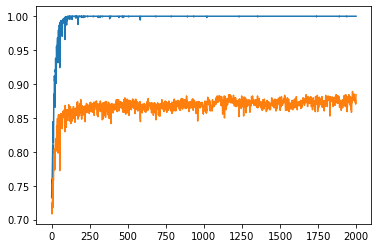

In [19]:
plt.plot(relu_train)
plt.plot(relu_test)

In [20]:
max(relu_test)

0.8888888888888888

In [21]:
eeg = EEGNet(activation='LeakyReLU')
eeg.cuda()
print(eeg)

EEGNet(
  (activation): LeakyReLU(negative_slope=0.01)
  (FirstConv2D): Sequential(
    (0): Conv2d(1, 16, kernel_size=(1, 51), stride=(1, 1), padding=(0, 25), bias=False)
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (DepthwiseConv2D): Sequential(
    (0): Conv2d(16, 32, kernel_size=(2, 1), stride=(1, 1), groups=16, bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01)
    (3): AvgPool2d(kernel_size=(1, 4), stride=(1, 4), padding=0)
    (4): Dropout(p=0.25, inplace=False)
  )
  (SeparableConv2D): Sequential(
    (0): Conv2d(32, 32, kernel_size=(1, 15), stride=(1, 1), padding=(0, 7), bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01)
    (3): AvgPool2d(kernel_size=(1, 8), stride=(1, 8), padding=0)
    (4): Dropout(p=0.25, inplace=False)
    (5): Flatten(start_dim=

In [22]:
epochs = 2000
optimizer = torch.optim.Adam(eeg.parameters(), lr=1e-3)
crossentropy = nn.CrossEntropyLoss().to(device)

In [23]:
leaky_relu_train = []
leaky_relu_test = []

for epoch in range(epochs):
    eeg.train()
    for x, label in dataloader:
        x = x.to(device)
        label = label.to(device, dtype=torch.long)
        output = eeg(x)
        loss = crossentropy(output, label)

        # backward propagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # check accurancy of each epoch
    eeg.eval()
    with torch.no_grad():
        output = eeg(x_train)
        pred = np.argmax(output.cpu().detach().numpy(), axis=1)
        leaky_relu_train.append(1 - np.average(np.abs(pred - y_train.cpu().detach().numpy())))
        output = eeg(x_test)
        pred = np.argmax(output.cpu().detach().numpy(), axis=1)
        leaky_relu_test.append(1 - np.average(np.abs(pred - y_test.cpu().detach().numpy())))

        if epoch % 10 == 0:
            print("epoch %d, training accuracy: %0.6f, testing accuracy: %0.6f"
                  % (epoch, leaky_relu_train[-1], leaky_relu_test[-1]))

epoch 0, training accuracy: 0.683333, testing accuracy: 0.655556
epoch 10, training accuracy: 0.788889, testing accuracy: 0.725926
epoch 20, training accuracy: 0.865741, testing accuracy: 0.789815
epoch 30, training accuracy: 0.943519, testing accuracy: 0.821296
epoch 40, training accuracy: 0.946296, testing accuracy: 0.815741
epoch 50, training accuracy: 0.980556, testing accuracy: 0.831481
epoch 60, training accuracy: 0.979630, testing accuracy: 0.830556
epoch 70, training accuracy: 0.988889, testing accuracy: 0.830556
epoch 80, training accuracy: 0.996296, testing accuracy: 0.837037
epoch 90, training accuracy: 0.994444, testing accuracy: 0.832407
epoch 100, training accuracy: 0.998148, testing accuracy: 0.837963
epoch 110, training accuracy: 0.999074, testing accuracy: 0.843519
epoch 120, training accuracy: 1.000000, testing accuracy: 0.851852
epoch 130, training accuracy: 1.000000, testing accuracy: 0.847222
epoch 140, training accuracy: 1.000000, testing accuracy: 0.841667
epoch 

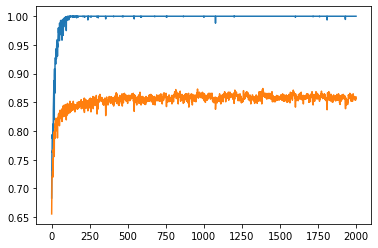

In [24]:
plt.plot(leaky_relu_train)
plt.plot(leaky_relu_test)

In [25]:
max(leaky_relu_test)

0.8740740740740741

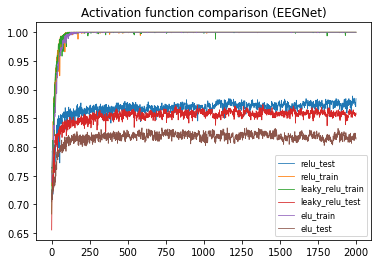

In [26]:
plt.plot(relu_test, linewidth=0.8, label='relu_test')
plt.plot(relu_train, linewidth=0.8, label='relu_train')
plt.plot(leaky_relu_train, linewidth=0.8, label='leaky_relu_train')
plt.plot(leaky_relu_test, linewidth=0.8, label='leaky_relu_test')
plt.plot(elu_train, linewidth=0.8, label='elu_train')
plt.plot(elu_test, linewidth=0.8, label='elu_test')
plt.title('Activation function comparison (EEGNet)')
plt.legend(fontsize=8)

## Train DeepConvNet

In [27]:
dcn = DeepConvNet(activation='ELU')
dcn.cuda()
print(dcn)

DeepConvNet(
  (activation): ELU(alpha=1.0)
  (conv1): Sequential(
    (0): Conv2d(1, 25, kernel_size=(1, 5), stride=(1, 1))
    (1): Conv2d(25, 25, kernel_size=(2, 1), stride=(1, 1))
    (2): BatchNorm2d(25, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): ELU(alpha=1.0)
    (4): MaxPool2d(kernel_size=(1, 2), stride=(1, 2), padding=0, dilation=1, ceil_mode=False)
    (5): Dropout(p=0.5, inplace=False)
  )
  (conv2): Sequential(
    (0): Conv2d(25, 50, kernel_size=(1, 5), stride=(1, 1))
    (1): BatchNorm2d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ELU(alpha=1.0)
    (3): MaxPool2d(kernel_size=(1, 2), stride=(1, 2), padding=0, dilation=1, ceil_mode=False)
    (4): Dropout(p=0.5, inplace=False)
  )
  (conv3): Sequential(
    (0): Conv2d(50, 100, kernel_size=(1, 5), stride=(1, 1))
    (1): BatchNorm2d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ELU(alpha=1.0)
    (3): MaxPool2d(kernel_size=(1, 2)

In [28]:
epochs = 2000
optimizer = torch.optim.Adam(dcn.parameters(), lr=5e-4)
crossentropy = nn.CrossEntropyLoss().to(device)

In [29]:
elu_train = []
elu_test = []

for epoch in range(epochs):
    dcn.train()
    for x, label in dataloader:
        x = x.to(device)
        label = label.to(device, dtype=torch.long)
        output = dcn(x)
        loss = crossentropy(output, label)

        # backward propagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # check accurancy of each epoch
    dcn.eval()
    with torch.no_grad():
        output = dcn(x_train)
        pred = np.argmax(output.cpu().detach().numpy(), axis=1)
        elu_train.append(1 - np.average(np.abs(pred - y_train.cpu().detach().numpy())))
        output = dcn(x_test)
        pred = np.argmax(output.cpu().detach().numpy(), axis=1)
        elu_test.append(1 - np.average(np.abs(pred - y_test.cpu().detach().numpy())))

        if epoch % 10 == 0:
            print("epoch %d, training accuracy: %0.6f, testing accuracy: %0.6f"
                  % (epoch, elu_train[-1], elu_test[-1]))

C:\Users\Yi-ann\AppData\Local\Programs\Python\Python38\lib\site-packages\torch\nn\modules\container.py:119: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
epoch 0, training accuracy: 0.573148, testing accuracy: 0.575000
epoch 10, training accuracy: 0.790741, testing accuracy: 0.723148
epoch 20, training accuracy: 0.819444, testing accuracy: 0.762037
epoch 30, training accuracy: 0.839815, testing accuracy: 0.781481
epoch 40, training accuracy: 0.854630, testing accuracy: 0.796296
epoch 50, training accuracy: 0.856481, testing accuracy: 0.792593
epoch 60, training accuracy: 0.863889, testing accuracy: 0.791667
epoch 70, training accuracy: 0.876852, testing accuracy: 0.793519
epoch 80, training accuracy: 0.885185, testing accuracy: 0.795370
epoch 90, training accuracy: 0.900926, testing accuracy: 0.791667
epoch 100, training accuracy: 0.895370, testing accuracy: 0.802778
epoch 110, training a

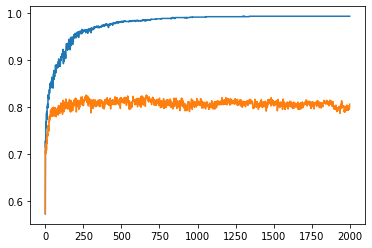

In [30]:
plt.plot(elu_train)
plt.plot(elu_test)

In [31]:
max(elu_test)

0.825925925925926

In [32]:
dcn = DeepConvNet(activation='ReLU')
dcn.cuda()
print(dcn)

DeepConvNet(
  (activation): ReLU()
  (conv1): Sequential(
    (0): Conv2d(1, 25, kernel_size=(1, 5), stride=(1, 1))
    (1): Conv2d(25, 25, kernel_size=(2, 1), stride=(1, 1))
    (2): BatchNorm2d(25, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): ReLU()
    (4): MaxPool2d(kernel_size=(1, 2), stride=(1, 2), padding=0, dilation=1, ceil_mode=False)
    (5): Dropout(p=0.5, inplace=False)
  )
  (conv2): Sequential(
    (0): Conv2d(25, 50, kernel_size=(1, 5), stride=(1, 1))
    (1): BatchNorm2d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=(1, 2), stride=(1, 2), padding=0, dilation=1, ceil_mode=False)
    (4): Dropout(p=0.5, inplace=False)
  )
  (conv3): Sequential(
    (0): Conv2d(50, 100, kernel_size=(1, 5), stride=(1, 1))
    (1): BatchNorm2d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=(1, 2), stride=(1, 2), padding=0, dila

In [33]:
epochs = 2000
optimizer = torch.optim.Adam(dcn.parameters(), lr=5e-4)
crossentropy = nn.CrossEntropyLoss().to(device)

In [34]:
relu_train = []
relu_test = []

for epoch in range(epochs):
    dcn.train()
    for x, label in dataloader:
        x = x.to(device)
        label = label.to(device, dtype=torch.long)
        output = dcn(x)
        loss = crossentropy(output, label)

        # backward propagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # check accurancy of each epoch
    dcn.eval()
    with torch.no_grad():
        output = dcn(x_train)
        pred = np.argmax(output.cpu().detach().numpy(), axis=1)
        relu_train.append(1 - np.average(np.abs(pred - y_train.cpu().detach().numpy())))
        output = dcn(x_test)
        pred = np.argmax(output.cpu().detach().numpy(), axis=1)
        relu_test.append(1 - np.average(np.abs(pred - y_test.cpu().detach().numpy())))

        if epoch % 10 == 0:
            print("epoch %d, training accuracy: %0.6f, testing accuracy: %0.6f"
                  % (epoch, relu_train[-1], relu_test[-1]))

epoch 0, training accuracy: 0.509259, testing accuracy: 0.503704
epoch 10, training accuracy: 0.783333, testing accuracy: 0.743519
epoch 20, training accuracy: 0.776852, testing accuracy: 0.752778
epoch 30, training accuracy: 0.818519, testing accuracy: 0.783333
epoch 40, training accuracy: 0.836111, testing accuracy: 0.788889
epoch 50, training accuracy: 0.820370, testing accuracy: 0.759259
epoch 60, training accuracy: 0.872222, testing accuracy: 0.787037
epoch 70, training accuracy: 0.850000, testing accuracy: 0.775000
epoch 80, training accuracy: 0.884259, testing accuracy: 0.789815
epoch 90, training accuracy: 0.842593, testing accuracy: 0.754630
epoch 100, training accuracy: 0.860185, testing accuracy: 0.775000
epoch 110, training accuracy: 0.884259, testing accuracy: 0.775926
epoch 120, training accuracy: 0.887037, testing accuracy: 0.777778
epoch 130, training accuracy: 0.877778, testing accuracy: 0.778704
epoch 140, training accuracy: 0.841667, testing accuracy: 0.751852
epoch 

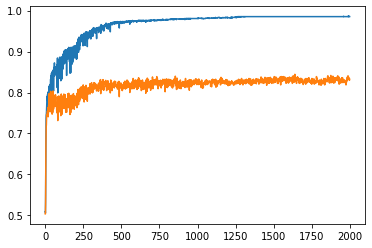

In [35]:
plt.plot(relu_train)
plt.plot(relu_test)

In [36]:
max(relu_test)

0.8444444444444444

In [37]:
dcn = DeepConvNet(activation='LeakyReLU')
dcn.cuda()
print(dcn)

DeepConvNet(
  (activation): LeakyReLU(negative_slope=0.01)
  (conv1): Sequential(
    (0): Conv2d(1, 25, kernel_size=(1, 5), stride=(1, 1))
    (1): Conv2d(25, 25, kernel_size=(2, 1), stride=(1, 1))
    (2): BatchNorm2d(25, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): LeakyReLU(negative_slope=0.01)
    (4): MaxPool2d(kernel_size=(1, 2), stride=(1, 2), padding=0, dilation=1, ceil_mode=False)
    (5): Dropout(p=0.5, inplace=False)
  )
  (conv2): Sequential(
    (0): Conv2d(25, 50, kernel_size=(1, 5), stride=(1, 1))
    (1): BatchNorm2d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01)
    (3): MaxPool2d(kernel_size=(1, 2), stride=(1, 2), padding=0, dilation=1, ceil_mode=False)
    (4): Dropout(p=0.5, inplace=False)
  )
  (conv3): Sequential(
    (0): Conv2d(50, 100, kernel_size=(1, 5), stride=(1, 1))
    (1): BatchNorm2d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): Leak

In [38]:
epochs = 2000
optimizer = torch.optim.Adam(dcn.parameters(), lr=5e-4)
crossentropy = nn.CrossEntropyLoss().to(device)

In [39]:
leaky_relu_train = []
leaky_relu_test = []

for epoch in range(epochs):
    dcn.train()
    for x, label in dataloader:
        x = x.to(device)
        label = label.to(device, dtype=torch.long)
        output = dcn(x)
        loss = crossentropy(output, label)

        # backward propagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # check accurancy of each epoch
    dcn.eval()
    with torch.no_grad():
        output = dcn(x_train)
        pred = np.argmax(output.cpu().detach().numpy(), axis=1)
        leaky_relu_train.append(1 - np.average(np.abs(pred - y_train.cpu().detach().numpy())))
        output = dcn(x_test)
        pred = np.argmax(output.cpu().detach().numpy(), axis=1)
        leaky_relu_test.append(1 - np.average(np.abs(pred - y_test.cpu().detach().numpy())))

        if epoch % 10 == 0:
            print("epoch %d, training accuracy: %0.6f, testing accuracy: %0.6f"
                  % (epoch, leaky_relu_train[-1], leaky_relu_test[-1]))

epoch 0, training accuracy: 0.612963, testing accuracy: 0.603704
epoch 10, training accuracy: 0.774074, testing accuracy: 0.737963
epoch 20, training accuracy: 0.773148, testing accuracy: 0.750926
epoch 30, training accuracy: 0.815741, testing accuracy: 0.779630
epoch 40, training accuracy: 0.834259, testing accuracy: 0.776852
epoch 50, training accuracy: 0.818519, testing accuracy: 0.755556
epoch 60, training accuracy: 0.855556, testing accuracy: 0.781481
epoch 70, training accuracy: 0.862963, testing accuracy: 0.790741
epoch 80, training accuracy: 0.846296, testing accuracy: 0.759259
epoch 90, training accuracy: 0.893519, testing accuracy: 0.788889
epoch 100, training accuracy: 0.865741, testing accuracy: 0.766667
epoch 110, training accuracy: 0.873148, testing accuracy: 0.775000
epoch 120, training accuracy: 0.892593, testing accuracy: 0.782407
epoch 130, training accuracy: 0.908333, testing accuracy: 0.793519
epoch 140, training accuracy: 0.898148, testing accuracy: 0.778704
epoch 

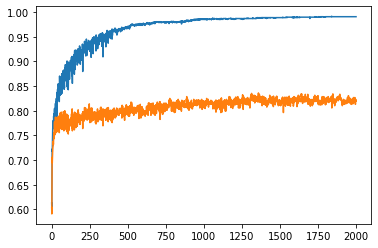

In [40]:
plt.plot(leaky_relu_train)
plt.plot(leaky_relu_test)

In [41]:
max(leaky_relu_test)

0.8361111111111111

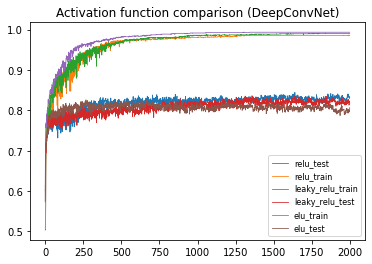

In [42]:
plt.plot(relu_test, linewidth=0.8, label='relu_test')
plt.plot(relu_train, linewidth=0.8, label='relu_train')
plt.plot(leaky_relu_train, linewidth=0.8, label='leaky_relu_train')
plt.plot(leaky_relu_test, linewidth=0.8, label='leaky_relu_test')
plt.plot(elu_train, linewidth=0.8, label='elu_train')
plt.plot(elu_test, linewidth=0.8, label='elu_test')
plt.title('Activation function comparison (DeepConvNet)')
plt.legend(fontsize=8)